In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm
from tqdm.notebook import tqdm
import pickle
import timeit
from td_algorithm_funcs import get_prop_v2, get_prop_abs_v2, get_rate, simulate_traj

from scipy.sparse import dok_array, csr_array, coo_array

In [199]:
def get_prop_abs_v3(x_s, force, D,dt,dx, N_border=None, side = 'r'):
    # x(t-tau), x(t), res
    N_x = len(x_s)
    half_x_s = np.arange(x_s[0],x_s[-1]+dx/4,dx/2)
    
    
    
    R_abs = np.zeros(( len(half_x_s),N_x, N_x))
    
    F = force(half_x_s)
    lp = D / dx**2 * np.exp((F*dx/D)/2)  # r_i->i+1
    ln = D / dx**2 * np.exp(-(F*dx/D)/2)  # r_i+1->i
    if side == 'r':
        if N_border is None:
            N_border = N_x
        R_abs[:,0,0] = -lp
        R_abs[:,np.arange(1,N_border),np.arange(1,N_border)] = -(lp[:,None]+ln[:,None]) # -(r_i->i+1 + r_i->i-1) ????
        R_abs[:,np.arange(0,N_border-1),np.arange(1,N_border)] = ln[:,None]
        R_abs[:,np.arange(1,N_border),np.arange(0,N_border-1)] = lp[:,None]
    elif side == 'l':
        if N_border is None:
            N_border = 0
        R_abs[:,-1,-1] = -ln
        R_abs[:,np.arange(N_border,N_x-1),np.arange(N_border,N_x-1)] = -(lp[:,None]+ln[:,None]) # -(r_i->i+1 + r_i->i-1) ????
        R_abs[:,np.arange(N_border,N_x-1),np.arange(N_border+1,N_x)] = ln[:,None]
        R_abs[:,np.arange(N_border+1,N_x),np.arange(N_border,N_x-1)] = lp[:,None]
    elif side == 'lr':
        if N_border is not None:
            print('for lr N_border is ignored')
        R_abs[:,np.arange(0,N_x),np.arange(0,N_x)] = -(lp[:,None]+ln[:,None]) # -(r_i->i+1 + r_i->i-1) ????
        R_abs[:,np.arange(0,N_x-1),np.arange(1,N_x)] = ln[:,None]
        R_abs[:,np.arange(1,N_x),np.arange(0,N_x-1)] = lp[:,None]
    
    prop_parts = expm(R_abs*dt/4, )
    
    prop_abs = np.empty((N_x,N_x,N_x,N_x))
    a,b = np.meshgrid(np.arange(N_x),np.arange(N_x))
    prop_abs[a,b] = prop_parts[2*a] @ prop_parts[a+b]@prop_parts[a+b]@prop_parts[2*b]
    
    
    if np.any(np.isnan(prop_abs)):
        print('CAREFUL: nan in prop, maybe because of to high values in potential')
    return prop_abs

def create_R(N_x, ntau, prop):
    all_states = np.arange(0, N_x**(ntau+1))

    # staetes # 1 * x(t-tau), N_x*x(t-tau1+1dt), ... , N_x**ntau * x(t)

    lm = all_states%N_x + (all_states//N_x)%N_x  #mean t-tau state
    lt = all_states//N_x**(ntau)             # t state
    all_next_states = (all_states//N_x)[:,None] + ((N_x**ntau)*(np.arange(0,N_x)))[None,:]

    R = np.zeros((N_x**(ntau+1),N_x**(ntau+1)))
    R[all_next_states, all_states[:,None].repeat(N_x, axis=1)] = prop[lm,:,lt]

    end_states = np.stack([all_states[all_states//N_x**ntau == i] for i in range(N_x)])
    return R, all_states, end_states

def create_R_v1(N_x, ntau, prop):
    all_states = np.arange(0, N_x**(ntau+1))

    # staetes # 1 * x(t-tau), N_x*x(t-tau1+1dt), ... , N_x**ntau * x(t)

    lm = all_states%N_x + (all_states//N_x)%N_x  #mean t-tau state
    lt = all_states//N_x**(ntau)             # t state
    all_next_states = (all_states//N_x)[:,None] + ((N_x**ntau)*(np.arange(0,N_x)))[None,:]

    R = coo_array( (prop[lm,:,lt].flatten(),
                    ( all_next_states.flatten(), all_states.repeat(N_x))) 
                  , shape = (N_x**(ntau+1),N_x**(ntau+1)))
    
    R = csr_array(R)
    end_states = np.stack([all_states[all_states//N_x**ntau == i] for i in range(N_x)])
    return R, all_states, end_states

def create_R_v2(N_x, ntau, prop):
    all_states = np.arange(0, N_x**(ntau+1))

    # staetes # 1 * x(t-tau), N_x*x(t-tau1+1dt), ... , N_x**ntau * x(t)

    lm1 = all_states%N_x  # t-tau state
    lm2 = (all_states//N_x)%N_x #t-tau+1 state
    lt = all_states//N_x**(ntau)             # t state
    all_next_states = (all_states//N_x)[:,None] + ((N_x**ntau)*(np.arange(0,N_x)))[None,:]

    #R = np.zeros((N_x**(ntau+1),N_x**(ntau+1)))
    #R[all_next_states, all_states[:,None].repeat(N_x, axis=1)] = prop[lm1,lm2,:,lt]
    R = coo_array( (prop[lm1,lm2,:,lt].flatten(),
                    ( all_next_states.flatten(), all_states.repeat(N_x))) 
                  , shape = (N_x**(ntau+1),N_x**(ntau+1)))
    
    R = csr_array(R)
    end_states = np.stack([all_states[all_states//N_x**ntau == i] for i in range(N_x)])
    return R, all_states, end_states

def get_dyn(R, i_zero, N_t, N_x, ntau, end_states):
    initial_state = np.sum(i_zero*(N_x**np.arange(0,ntau+1)))
    p = np.zeros(N_x**(ntau+1), dtype = float)
    p[initial_state] = 1.

    res = np.empty((N_t, len(p)))
    res[0] = p
    for i in tqdm(range(1,N_t)):
        res[i] = R@res[i-1]
    
    one_time_p = np.sum(res[:, end_states], axis = 2)
    return res, one_time_p


def get_dyn_v2(R, i_zero, N_t,N_x, ntau, end_states):
    initial_state = np.sum(i_zero*(N_x**np.arange(0,ntau+1)))
    p = np.zeros(N_x**(ntau+1), dtype = float)
    p[initial_state] = 1.
    one_time_p = np.empty((N_t,N_x))
    one_time_p[0] = np.sum(p[end_states], axis = 1)
    for i in tqdm(range(1,N_t)):
        p = R@p
        one_time_p[i] = np.sum(p[end_states], axis = 1)
    
    return p, one_time_p


def get_p_x4_short_time(x,k,tau,s):
    ga = s*(1+3*tau*k*x**2)
    p_not_notmed = np.exp(-x**2/(3*tau*s**2)+(1-18*tau**2*k*s**2)/(9*tau**2*k*s**2)*np.log(1+3*tau*k*x**2))
    return p_not_notmed/np.sum(p_not_notmed)

# One example

In [217]:
# k = 1
# tau = 0.5
# D = 1/2
# s = np.sqrt(2*D)
# N_t = 100
# dt = tau/4 if tau > 0 else 5e-2
# dx = 1/2
#sb = 20

k = 3
tau = 0.2
D = 1e-6
s = np.sqrt(2*D)
N_t = 200
dt = tau/3 if tau > 0 else 5e-2
dx = 3e-4 #1e-4
sb = 15*dx#0.005

f = 15
N_p = 20_000


ntau = round(tau/dt)
ts = np.arange(0,N_t)*dt
ts_r = ts[1:]


# jump over zero as x point
x_s = np.arange(-sb,sb+1e-6,dx)
bins = np.arange(-sb-dx/2,sb+dx/2+1e-5,dx)
N_x = len(x_s)

# border = 0
# def force(x,*args):
#      return -k*x

border = 0
def force(x,*args):
    return -k*x**3*1e6

# v_min = -2e-6
# border = 0.0015
# def force(x):
#     a = -v_min/border**4
#     b = -2*v_min/border**2
#     return -4*a*x**3+2*b*x

i_zero = np.argmin((x_s+border)**2)

In [218]:
prop = get_prop_abs_v2(x_s,force, D, dt, dx, side = 'lr')
prop2 = get_prop_abs_v3(x_s,force, D, dt, dx, side = 'lr')
prop.shape, prop2.shape

((61, 31, 31), (31, 31, 31, 31))

In [219]:
N_x**6

887503681

In [220]:
R, all_states, end_states = create_R_v1(N_x, ntau, prop)
R2, _, end_states = create_R_v2(N_x, ntau, prop2)
R2.shape

(923521, 923521)

In [221]:
res, one_time_p = get_dyn_v2(R, i_zero, N_t,N_x, ntau, end_states)
res2, one_time_p2 = get_dyn_v2(R2, i_zero, N_t,N_x, ntau, end_states)

  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

In [222]:
pos = simulate_traj(N_p=N_p, N_loop=1, N_t=(N_t+ntau+2)*f, ntau=ntau*f, s=s, dt=dt/f,border=border, force=force)
all_pos = pos[0]
sim_hists = np.stack([np.histogram(all_pos[:,j], bins = bins)[0] for j in tqdm(range(all_pos.shape[-1]))])
sim_ts = np.arange(0, len(all_pos[0]))*dt/f -tau

  0%|          | 0/3029 [00:00<?, ?it/s]

/tmp/ipykernel_25598/1133333883.py:39: RuntimeWarning: overflow encountered in multiply
  return -k*x**3*1e6
/tmp/ipykernel_25598/1133333883.py:39: RuntimeWarning: overflow encountered in power
  return -k*x**3*1e6


  0%|          | 0/3075 [00:00<?, ?it/s]

In [223]:
short_time_p = get_p_x4_short_time(x_s, k*1e6,tau,s)

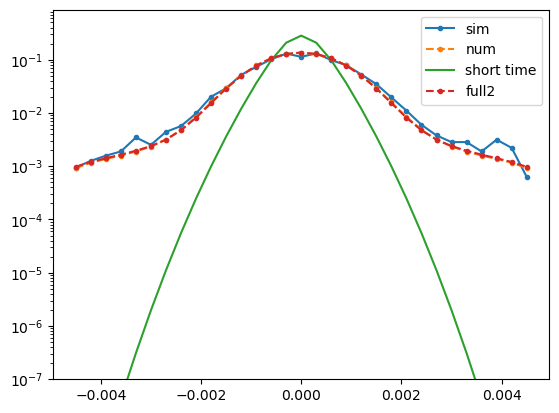

In [226]:
idx = 150
plt.plot(x_s,sim_hists[f*(idx+ntau)]/sim_hists[f*(idx+ntau)].sum(),'.-', label='sim')
plt.plot(x_s,one_time_p[idx]/one_time_p[idx].sum(),'.--', label='num')
plt.plot(x_s,short_time_p, label='short time')
plt.plot(x_s,one_time_p2[idx]/one_time_p2[idx].sum(),'.--', label='full2')
plt.yscale('log')
plt.ylim(1e-7, plt.ylim()[1])
plt.legend()

In [214]:
### sim_var = np.var(pos, axis = 1)
sim_p = sim_hists/np.sum(sim_hists, axis = 1)[:,None]
sim_hist_var = np.sum(sim_p*x_s[None,:]**2 - (sim_p*x_s[None,:])**2, axis = 1)

num_p = one_time_p[:,:]/np.sum(one_time_p, axis = 1)[:,None]
num_var = np.sum(num_p*x_s[None,:]**2 - (num_p*x_s[None,:])**2, axis = 1)

num_p2 = one_time_p2[:,:]/np.sum(one_time_p2, axis = 1)[:,None]
num_var2 = np.sum(num_p2*x_s[None,:]**2 - (num_p2*x_s[None,:])**2, axis = 1)

short_time_var = np.sum(short_time_p*x_s[None,:]**2 - (short_time_p*x_s[None,:])**2, axis = 1)

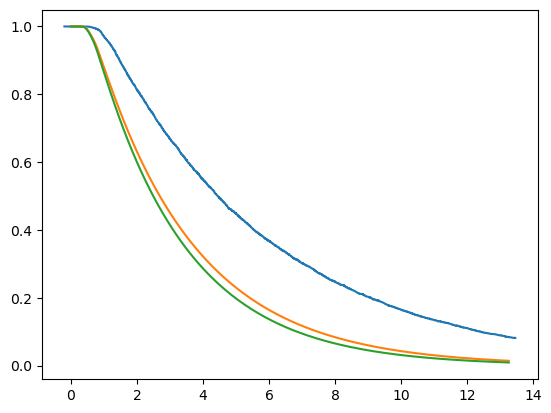

In [215]:
plt.plot(sim_ts,np.sum(sim_hists, axis = 1)/N_p)
plt.plot(ts,np.sum(one_time_p, axis = 1))
plt.plot(ts,np.sum(one_time_p2, axis = 1))

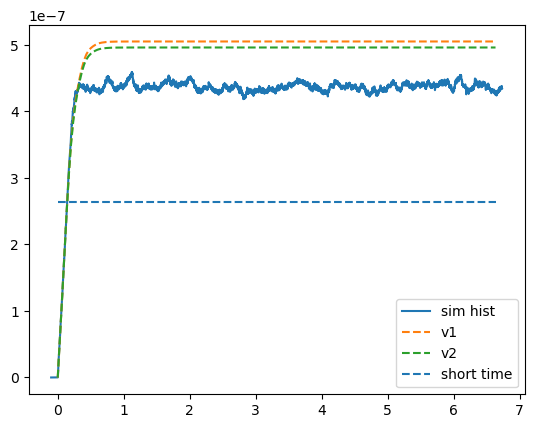

In [192]:
#plt.plot(sim_ts,sim_var[0], label='sim')
plt.plot(sim_ts,sim_hist_var, label='sim hist')
plt.plot(ts, num_var, label='v1', ls = '--')
plt.plot(ts, num_var2, label='v2', ls = '--')
#plt.xlim(0,2)
plt.hlines(short_time_var,ts[0],ts[-1],ls='--', label='short time')
plt.legend()

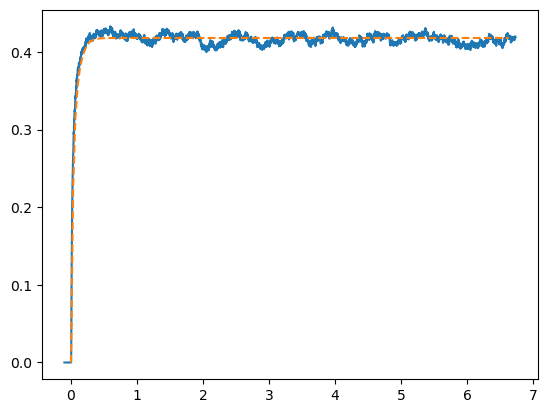

In [193]:
plt.plot(sim_ts, np.sum(sim_hists[:,x_s > 0], axis = 1)/np.sum(sim_hists, axis = 1))
plt.plot(ts, np.sum(one_time_p[:,x_s > 0], axis = 1)/np.sum(one_time_p, axis = 1),'--')

# The Loop

In [153]:
k = 3
D = 1e-6
s = np.sqrt(2*D)
N_t = 100
dx = 3e-4 #4e-4
sb = 15*dx#0.005

f = 30
N_p = 8_000


# jump over zero as x point
x_s = np.arange(-sb,sb+1e-6,dx)
bins = np.arange(-sb-dx/2,sb+dx/2+1e-5,dx)
N_x = len(x_s)

ltaus = np.array([0.01, 0.05, 0.1, 0.2,0.3,0.4,0.5,0.6])
sim_vars = np.empty(len(ltaus))
num_vars = np.empty(len(ltaus))
sim_hist_vars = np.empty(len(ltaus))
short_time_vars = np.empty(len(ltaus))

tau_frac = 3

def force(x,*args):
    return -k*x**3*1e6

# def force(x,*args):
#      return -k*x
i_zero = np.argmin(force(x_s)**2)

for i,ltau in enumerate(tqdm(ltaus)):
    
    
    ldt = ltau/tau_frac if ltau > 0 else 5e-2
    lntau = round(ltau/ldt)
    
    print(ldt, lntau)
    
    # prop = get_prop_abs_v2(x_s,force, D, ldt, dx, side = 'lr')
    # R, all_states, end_states = create_R(N_x, lntau, prop)
    #res, hists = get_dyn(R, i_zero, N_x, lntau)
    prop = get_prop_abs_v3(x_s,force, D, ldt, dx, side = 'lr')
    R, all_states, end_states = create_R_v2(N_x, lntau, prop)
    res, hists = get_dyn_v2(R, i_zero,N_t, N_x, lntau, end_states)
    
    
    pos = simulate_traj(N_p=N_p, N_loop=1, N_t=(N_t+lntau+2)*f, ntau=lntau*f, s=s, dt=ldt/f,border=0, force=force)
    all_pos = pos[0]
    sim_hists = [np.histogram(all_pos[:,j], bins = bins)[0] for j in tqdm(range(all_pos.shape[-1]))]
    
    short_time_p = get_p_x4_short_time(x_s, k*1e6,ltau,s)
    short_time_var = np.sum(short_time_p*x_s[None,:]**2 - (short_time_p*x_s[None,:])**2, axis = 1)
 
    sim_var = np.var(pos, axis = 1)
    sim_p = sim_hists/np.sum(sim_hists, axis = 1)[:,None]
    sim_hist_var = np.sum(sim_p*x_s[None,:]**2 - (sim_p*x_s[None,:])**2, axis = 1)
    
    num_p = hists[:,:]/np.sum(hists, axis = 1)[:,None]
    num_var = np.sum(num_p*x_s[None,:]**2 - (num_p*x_s[None,:])**2, axis = 1)

    
    sim_vars[i] = np.mean(sim_var[0,-f*N_t//2:])
    num_vars[i] = np.mean(num_var[-N_t//2:])
    sim_hist_vars[i] = np.mean(sim_hist_var[-f*N_t//2:])
    short_time_vars[i] = short_time_var
    
# with open(f'nummeric_results/sim_vs_num_v4_emb{tau_frac}_old.pkl', 'wb') as file:
#     pickle.dump({'ltaus':ltaus,
#                  'sim_vars':sim_vars,
#                  'sim_hist_vars':sim_hist_vars,
#                  'num_vars':num_vars
#                 }, file)

  0%|          | 0/8 [00:00<?, ?it/s]

0.0033333333333333335 3


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/3059 [00:00<?, ?it/s]

  0%|          | 0/3150 [00:00<?, ?it/s]

0.016666666666666666 3


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/3059 [00:00<?, ?it/s]

  0%|          | 0/3150 [00:00<?, ?it/s]

0.03333333333333333 3


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/3059 [00:00<?, ?it/s]

/tmp/ipykernel_25598/570000416.py:26: RuntimeWarning: overflow encountered in multiply
  return -k*x**3*1e6
/tmp/ipykernel_25598/570000416.py:26: RuntimeWarning: overflow encountered in power
  return -k*x**3*1e6
/home/nils/Programmieren/overdampedDelayHarmonicOscillator/td_algorithm_funcs.py:92: RuntimeWarning: invalid value encountered in add
  pos[:,:,i] = pos[:,:,i-1] + vel[:,:,i-1]*dt


  0%|          | 0/3150 [00:00<?, ?it/s]

/home/nils/anaconda3/envs/kroy/lib/python3.10/site-packages/numpy/core/_methods.py:213: RuntimeWarning: invalid value encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
/home/nils/anaconda3/envs/kroy/lib/python3.10/site-packages/numpy/core/_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/home/nils/anaconda3/envs/kroy/lib/python3.10/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


0.06666666666666667 3


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/3059 [00:00<?, ?it/s]

  0%|          | 0/3150 [00:00<?, ?it/s]

/home/nils/anaconda3/envs/kroy/lib/python3.10/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


0.09999999999999999 3


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/3059 [00:00<?, ?it/s]

  0%|          | 0/3150 [00:00<?, ?it/s]

0.13333333333333333 3


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/3059 [00:00<?, ?it/s]

  0%|          | 0/3150 [00:00<?, ?it/s]

0.16666666666666666 3


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/3059 [00:00<?, ?it/s]

  0%|          | 0/3150 [00:00<?, ?it/s]

/tmp/ipykernel_25598/570000416.py:56: RuntimeWarning: invalid value encountered in divide
  sim_p = sim_hists/np.sum(sim_hists, axis = 1)[:,None]


0.19999999999999998 3


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/3059 [00:00<?, ?it/s]

  0%|          | 0/3150 [00:00<?, ?it/s]

In [154]:
#short_time_approx_var = s**2/(2*k)*(1+k*ltaus)
#exact_sol = s**2/(2*k)*(1+np.sin(k*ltaus))/np.cos(k*ltaus)

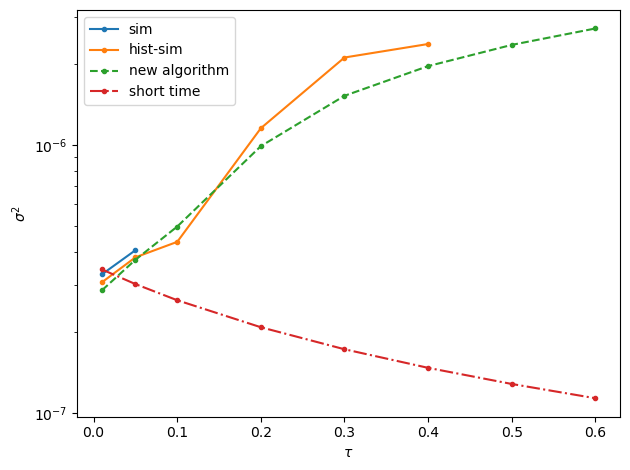

In [157]:
ax = plt.subplot()
plt.plot(ltaus,sim_vars,'.-', label='sim')
plt.plot(ltaus,sim_hist_vars,'.-', label='hist-sim')
plt.plot(ltaus,num_vars,'.--', label='new algorithm')
#plt.plot(ltaus,num_vars_2,'.--' ,label='v2')

if False:
    plt.plot(ltaus,short_time_approx_var ,'.-.',label='short time')
    plt.plot(ltaus[:-1],exact_sol[:-1] ,'.-.',label='exact')

    plt.ylim(1e-7,5e-5)
    plt.vlines([1/np.e /k, np.pi/2/k],*plt.ylim(), color='black')
    plt.text(0.5*1/np.e /k,              2e-7,'Regim I', ha='center', va='center')
    plt.text(0.5*(1/np.e /k+  np.pi/2/k),2e-7,'Regim II',ha='center', va='center')
    plt.text(1.1*(np.pi/2/k),            2e-7,'Regim III',ha='center', va='center')
else:
    plt.plot(ltaus,short_time_vars ,'.-.',label='short time')

plt.yscale('log')
plt.legend()
plt.xlabel(r'$\tau$')
plt.ylabel(r'$\sigma^2$')
plt.tight_layout()
#plt.savefig('Graphic_Results/varianz_compare.pdf')

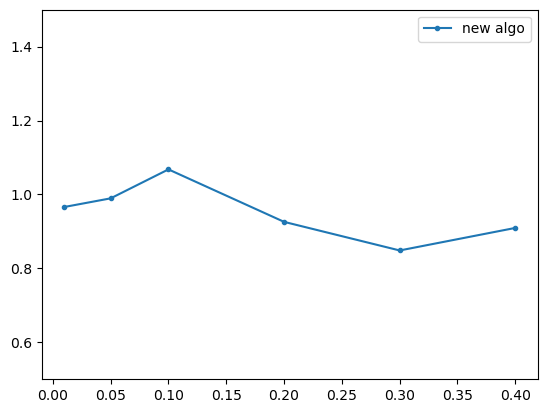

In [195]:
plt.plot(ltaus,np.sqrt(num_vars/sim_hist_vars),'.-', label='new algo')
#plt.plot(ltaus,num_vars_2/sim_vars,label='v2')
plt.ylim(0.5,1.5)

if False:
    y = 0.6
    plt.plot(ltaus,np.sqrt(short_time_approx_var/sim_hist_vars),'.-',label='short time')
    plt.vlines([1/np.e /k, np.pi/2/k],*plt.ylim(), color='black')
    plt.text(0.5*1/np.e /k,              y,'Regim I', ha='center', va='center')
    plt.text(0.5*(1/np.e /k+  np.pi/2/k),y,'Regim II',ha='center', va='center')
    plt.text(1.1*(np.pi/2/k),            y,'Regim III',ha='center', va='center')

    
plt.legend()

In [3]:
import numpy as np
np.array([[1,2,3]]).ndim

2